# Interplanetary Shock Parameters and Transformation to Normal Incidence Frame
author: Louis Richard

Example to shows how to convert shock related plasma data to the normal incidence frame. The same procedure can be used at the bow shock.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pyrfu import mms, pyrf
from pyrfu.plot import plot_spectr, plot_line

Load IGRF coefficients ...


Set path to MMS data

In [ ]:
mms.db_init(default="local", local="/data/mms")

## Non-exhaustive list of IP shock events observed by MMS (burst mode)

In [2]:
ipshock_events = [
    {
        "tint": ["2017-10-24T08:25:45.000000", "2017-10-24T08:27:45.000000"],
        "tintu": ["2017-10-24T08:26:36.000000", "2017-10-24T08:26:42.000000"],
        "tintd": ["2017-10-24T08:26:54.000000", "2017-10-24T08:27:04.000000"],
    },
    {
        "tint": ["2018-01-08T06:40:45.000000", "2018-01-08T06:41:30.000000"],
        "tintu": ["2018-01-08T06:40:45.000000", "2018-01-08T06:41:00.000000"],
        "tintd": ["2018-01-08T06:41:20.000000", "2018-01-08T06:41:30.000000"],
    },
    {
        "tint": ["2022-02-01T22:17:00.000000", "2022-02-01T22:20:00.000000"],
        "tintu": ["2022-02-01T22:18:08.000000", "2022-02-01T22:18:26.000000"],
        "tintd": ["2022-02-01T22:18:43.000000", "2022-02-01T22:18:56.000000"],
    },
    {
        "tint": ["2022-02-11T10:23:20.000000", "2022-02-11T10:25:10.000000"],
        "tintu": ["2022-02-11T10:24:05.000000", "2022-02-11T10:24:07.000000"],
        "tintd": ["2022-02-11T10:24:16.000000", "2022-02-11T10:24:22.000000"],
    },
]

## Select IP shock event

In [3]:
event_num = 0
reference_frame = "nif"
mms_id = 2

In [4]:
tint = ipshock_events[event_num]["tint"]
tintu = ipshock_events[event_num]["tintu"]
tintd = ipshock_events[event_num]["tintd"]

## Load data

In [5]:
# Spacecraft location
r_gse = mms.get_data("r_gse_mec_srvy_l2", tint, mms_id)

# Magnetic field
b_gse = mms.get_data("b_gse_fgm_brst_l2", tint, mms_id)

# Ion number density and bulk velocity
n_i = mms.get_data("ni_fpi_brst_l2", tint, mms_id)
v_gse_i = mms.get_data("vi_gse_fpi_brst_l2", tint, mms_id)

# Electron number density
n_e = mms.get_data("ne_fpi_brst_l2", tint, mms_id)

vdf_i = mms.get_data("pdi_fpi_brst_l2", tint, mms_id)
vdf_err_i = mms.get_data("pderri_fpi_brst_l2", tint, mms_id)
vdf_i.data.data[vdf_i.data.data < 1.1 * vdf_err_i.data.data] = 0.0

[14-Jun-23 11:14:26] INFO: Loading mms2_mec_r_gse...
[14-Jun-23 11:14:26] INFO: Loading mms2_fgm_b_gse_brst_l2...
[14-Jun-23 11:14:26] INFO: Loading mms2_dis_numberdensity_brst...
[14-Jun-23 11:14:26] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[14-Jun-23 11:14:26] INFO: Loading mms2_dis_bulkv_gse_brst...
[14-Jun-23 11:14:26] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[14-Jun-23 11:14:26] INFO: Loading mms2_des_numberdensity_brst...
[14-Jun-23 11:14:26] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[14-Jun-23 11:14:26] INFO: Loading mms2_dis_dist_brst...
[14-Jun-23 11:14:26] WARNING: /usr/local/lib/python3.

### Compute the shock normal and shock parameters (if normal incidence frame NIF selected)

In [6]:
if reference_frame.lower() == "nif":
    plp = {}
    plp["b_u"] = np.mean(pyrf.time_clip(b_gse, tintu).data, axis=0)
    plp["n_u"] = np.mean(pyrf.time_clip(n_i, tintu).data, axis=0)
    plp["v_u"] = np.mean(pyrf.time_clip(v_gse_i, tintu).data, axis=0)
    plp["b_d"] = np.mean(pyrf.time_clip(b_gse, tintd).data, axis=0)
    plp["n_d"] = np.mean(pyrf.time_clip(n_i, tintd).data, axis=0)
    plp["v_d"] = np.mean(pyrf.time_clip(v_gse_i, tintd).data, axis=0)
    plp["r_xyz"] = np.mean(r_gse.data, axis=0)

    # get normal and shock speed
    nst = pyrf.shock_normal(plp)

    # let's use mixed mode 3 as normal
    nvec = nst["n"]["mx_3"]

    # and the SB for shock speed
    v_sh = nst["v_sh"]["sb"]["mx_3"]

    # then add info to plp
    plp["nvec"] = nvec
    plp["v_sh"] = v_sh
    plp["ref_sys"] = reference_frame.lower()

    # set coordinate system
    t2vec = np.cross(nvec, plp["b_u"])
    t2vec /= np.linalg.norm(t2vec)

    t1vec = np.cross(t2vec, nvec)
    t1vec /= np.linalg.norm(t1vec)

    t1vec = np.tile(t1vec, (len(vdf_i.time), 1))
    t2vec = np.tile(t2vec, (len(vdf_i.time), 1))
    nvec = np.tile(nvec, (len(vdf_i.time), 1))

    # rotation matrix to shock-aligned coordinate system
    r_mat = np.transpose(np.stack([nvec, t1vec, t2vec]), [1, 2, 0])
    r_mat = pyrf.ts_tensor_xyz(vdf_i.time.data, r_mat)

    # Get more shock parameters
    shp = pyrf.shock_parameters(plp)

    # velocity of the NI frame in the SC frame
    v_nif = shp["v_nif_u"]
elif reference_frame.lower() == "s/c":
    r_mat = np.tile(np.eye(3), (len(vdf_i.time), 1, 1))
    r_mat = pyrf.ts_tensor_xyz(vdf_i.time.data, r_mat)
    v_nif = np.zeros(3)
    nvec = r_mat.data[:, :, 0]

## Reduce ion VDF along the normal (if NIF selected) or x GSE

In [7]:
# Number of Monte Carlo iterations per bin. Decrease to improve performance, increase to improve plot.
n_mc = 2e2


if reference_frame.lower() == "nif":
    # Define velocity grid
    v_lim = [0.0, 1000.0]  # km/s
    v_1d = np.linspace(v_lim[0], v_lim[1], 100) * 1e3

    # Reduce ion disctribution
    f1d = mms.reduce(vdf_i, projection_dim="1d", xyz=r_mat, n_mc=n_mc, vg=v_1d)
    f1d = f1d.assign_coords(vx=f1d.vx.data - np.dot(v_nif, nvec[0, :]) / 1e3)

elif reference_frame.lower() == "s/c":
    # Define velocity grid
    v_lim = [-1000.0, 0.0]  # km/s
    v_1d = np.linspace(v_lim[0], v_lim[1], 100) * 1e3

    # Reduce ion disctribution
    f1d = mms.reduce(vdf_i, projection_dim="1d", xyz=r_mat, n_mc=n_mc, vg=v_1d)
    f1d = f1d.assign_coords(vx=f1d.vx.data - np.dot(v_nif, nvec[0, :]) / 1e3)

100%|████████████████████| 800/800 [00:02<00:00, 287.96it/s]


## Plot

In [8]:
legend_options = dict(
    handlelength=1, ncol=1, frameon=False, loc="upper left", bbox_to_anchor=(1.0, 1.0)
)

Text(0.5, 0.98, 'MMS 2 - IP shock in the NIF frame')

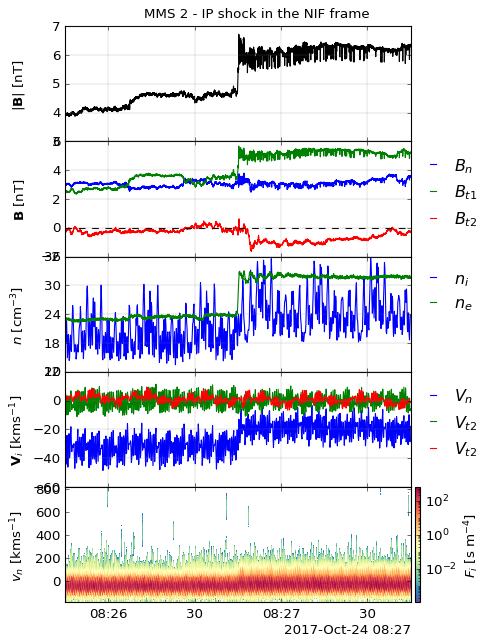

In [9]:
f, axs = plt.subplots(5, sharex="all", figsize=(6, 8))
f.subplots_adjust(hspace=0, left=0.1, right=0.82, bottom=0.05, top=0.95)
plot_line(axs[0], pyrf.norm(b_gse), color="k")
axs[0].set_ylabel("$|\\mathbf{B}|~[\\mathrm{nT}]$")

plot_line(axs[1], pyrf.new_xyz(b_gse, r_mat.data[0, ...]))
axs[1].axhline(0.0, color="k", linestyle="--")
axs[1].legend(["$B_{n}$", "$B_{t1}$", "$B_{t2}$"], **legend_options)
axs[1].set_ylabel("$\\mathbf{B}~[\\mathrm{nT}]$")

plot_line(axs[2], n_i, label="$n_i$")
plot_line(axs[2], n_e, label="$n_e$")
axs[2].legend(**legend_options)
axs[2].set_ylabel("$n~[\\mathrm{cm}^{-3}]$")

plot_line(axs[3], pyrf.new_xyz(v_gse_i - v_nif / 1e3, r_mat.data[0, ...]))
axs[3].legend(["$V_{n}$", "$V_{t2}$", "$V_{t2}$"], **legend_options)
axs[3].set_ylabel("$\\mathbf{V}_i~[\\mathrm{km} \\mathrm{s}^{-1}]$")

axs[4], caxs4 = plot_spectr(axs[4], f1d, cscale="log", cmap="Spectral_r")
axs[4].set_ylabel("$v_n~[\\mathrm{km} \\mathrm{s}^{-1}]$")
caxs4.set_ylabel("$F_i~[\\mathrm{s}~\\mathrm{m}^{-4}]$")

f.align_ylabels(axs)
f.suptitle(f"MMS {mms_id} - IP shock in the {reference_frame.upper()} frame")